In [1]:
import numpy as np
import numpy.linalg as lin
import numpy.random as npr 
import scipy.optimize as sco 
import time
from scipy import interpolate 
from scipy.linalg import expm
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

In [2]:
# Parameter Input
S0 = 100.0 # ini stock price
G = 100.0 # garantee level
T = 10 # maturity
m = 0.02 # R&E fee
me = 0.01441466502048007 # rider charge
N, X = 1024, 7.5 # FST param.
I, Path = 100000, 1000 # Monte Carlo param.
r = [0.04, 0.01] # risk-free interest rate
drift = [0.05, 0.02] # drift
sigma = [0.1, 0.2] # volatility
A = np.array([[-0.4, 0.4], [0.3, -0.3]]) # transition matrix
Pi = np.array([[0.9999], [0.0001]]) # ini state

In [93]:
# PV of Zero-coupon bond
def z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    return float(Z)
# Rho1 of Zero-coupon bond
def rho1_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = -np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One))) / 100
    return float(Z)
# Rho2 of Zero-coupon bond
def rho2_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z1 = np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One)))
    Z2 = -T * np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    Z = (Z1 + Z2) / 100
    return float(Z)
print('z(10) = %.16f' % z(r, T, A, Pi)) # 0.7784180374597731
print('rho1_z(10) = %.16f' % rho1_z(r, T, A, Pi)) # -0.0778336802081909
print('rho2_z(10) = %.16f' % rho2_z(r, T, A, Pi)) # -0.0000081235377864

z(10) = 0.7784180374597731
rho1_z(10) = -0.0778336802081909
rho2_z(10) = -0.0000081235377864


In [94]:
# Stochastic Motality Risk
def b(t):
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    B = (1 - np.exp(b * t)) / (c + d * np.exp(b * t))
    return B
def s(t):
    ini = 0.00495 # aged 50 years old in 2017
    # ini = 0.01164 # aged 60 years old in 2017
    # ini = 0.02255 # aged 70 years old in 2017
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    # A = 0
    # S_feller = np.exp(A + B(t)*ini)
    S = np.exp((1 - np.exp(b * t)) / (c + d * np.exp(b * t)) * ini)
    return S
print('s(0) = %.16f' % s(0)) # 1.0
print('s(10) = %.16f' % s(15)) # 0.8672053048004046

s(0) = 1.0000000000000000
s(10) = 0.8672053048004046


In [85]:
# Put and GMMB by Monte Carlo
def rsln_gmmbloss_mc(S0, G, T, r, sigma, m, me, A, Pi, I):
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    l1, l2 = A[0, 1], A[1, 0]
    if Pi[0] > Pi[1]:
        Ini_State = 1.0
    else:
        Ini_State = 2.0
    F = np.zeros((T + 1, I))   
    cf = np.zeros((T + 1, I)) 
    for t in range(T + 1):
        for i in range(I):
            LogStock = float(np.log(S0))
            Cur_Time = 0.0
            Cur_State = Ini_State
            tau1 = 0.0
            while Cur_Time < t: # Pr(tau_i > t) = exp(-lambda_i * t)
                p = npr.uniform(0, 1)
                if Cur_State == 1:
                    ExpRV = -1 * np.log(p) / l1
                else:
                    ExpRV = -1 * np.log(p) / l2
                if Cur_Time + ExpRV < t and Cur_State == 1:
                    tau1 = tau1 + ExpRV
                else:
                    if Cur_State == 1:
                        tau1 = tau1 + t - Cur_Time
                Cur_Time = Cur_Time + ExpRV
                if Cur_State == 1:
                    Cur_State = 2
                else:
                    Cur_State = 1
            SimRand = float(npr.standard_normal())
            LogFund = LogStock + (r1 - m - 0.5 * sigma1 ** 2) * tau1 + (r2 - m - 0.5 * sigma2 ** 2) * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2)
            F[t, i] = np.exp(LogFund)
            if t < T:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.exp(LogFund) * me * s(t)
            else:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.maximum(0, G - np.exp(LogFund))           
    Gmmb = np.mean(s(T) * cf[-1] - np.sum(cf[:-1], 0))
    return (np.mean(cf[-1]), Gmmb)
start = time.clock()
Results = rsln_gmmbloss_mc(S0, G, T, r, sigma, m, me, A, Pi, I)
# print('Put_MC = %.16f' % Results[0]) # 15.5436602771779686
print('GMMB_MC = %.16f' % Results[1]) # 0.0074412709822656
elapsed = (time.clock() - start)
print("Time used:", elapsed)

GMMB_MC = -24.0042476836356578
Time used: 169.92927050000435


In [95]:
def rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    p1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    p2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, p1)
    f2 = interpolate.PchipInterpolator(ST, p2)
    P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(P) # 13.8429656013946278
print('Put_FST = %.16f' % rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X))

Put_FST = 13.8429656013946278


In [96]:
def rsln_gmmb_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    P = rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, re1)
        f2 = interpolate.PchipInterpolator(ST, re2)
        Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Re = np.sum(Re)
    # calculate GMMB loss
    Loss = s(T) * P - Re
    return float(Loss)  # 0.0000000000005329
start = time.clock()
print('GMMB_FST = %.16f' % rsln_gmmb_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X))
elapsed = (time.clock() - start)
print("Time used:", elapsed)

GMMB_FST = 0.0000000000005329
Time used: 3.1175922000038554


In [97]:
def rsln_putdelta_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    delta_p1 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)) / (ST)).real
    delta_p2 = (ifft(1j * w * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)) / (ST)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, delta_p1)
    f2 = interpolate.PchipInterpolator(ST, delta_p2)
    Delta_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(Delta_P) # -0.2892064937563866
print('Delta_Put = %.16f' % rsln_putdelta_fst(S0, G, T, r, sigma, m, A, Pi, N, X))

Delta_Put = -0.2892064937563866


In [98]:
def rsln_gmmbdelta_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    Delta_P = rsln_putdelta_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Delta_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        delta_re1 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST)).real
        delta_re2 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, delta_re1)
        f2 = interpolate.PchipInterpolator(ST, delta_re2)
        Delta_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Delta = s(T) * Delta_P - np.sum(Delta_Re)
    return float(Delta) # -0.4007022754308916
print('Delta_GMMB = %.16f' % rsln_gmmbdelta_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X))

Delta_GMMB = -0.4007022754308916


In [99]:
def rsln_putgamma_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    gamma_p1 = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)) / (ST ** 2)).real
    gamma_p2 = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)) / (ST ** 2)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, gamma_p1)
    f2 = interpolate.PchipInterpolator(ST, gamma_p2)
    Gamma_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(Gamma_P) # 0.0062255454081478
print('Gamma_Put = %.16f' % rsln_putgamma_fst(S0, G, T, r, sigma, m, A, Pi, N, X))

Gamma_Put = 0.0062255454081478


In [100]:
def rsln_gmmbgamma_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    Gamma_P = rsln_putgamma_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Gamma_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        gamma_re1 = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST ** 2)).real
        gamma_re2 = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)) / (ST ** 2)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, gamma_re1)
        f2 = interpolate.PchipInterpolator(ST, gamma_re2)
        Gamma_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    # calculate GMMB delta
    Gamma = s(T) * Gamma_P - np.sum(Gamma_Re)
    return float(Gamma) # 0.0060459769788203
print('Gamma_GMMB = %.16f' % rsln_gmmbgamma_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X))

Gamma_GMMB = 0.0060459769788203


In [101]:
def rsln_putvega_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    vega1_p1 = ifft(-(1j * w + w ** 2) * sigma1 * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    vega1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, vega1_p1)
    f2 = interpolate.PchipInterpolator(ST, vega1_p2)
    Vega1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    vega2_p1 = ifft(0 * fft(payoff_p)).real
    vega2_p2 = ifft(-(1j * w + w ** 2) * sigma2 * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, vega2_p1)
    f2 = interpolate.PchipInterpolator(ST, vega2_p2)
    Vega2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Vega1_P), float(Vega2_P))
Results = rsln_putvega_fst(S0, G, T, r, sigma, m, A, Pi, N, X) 
print('Vega1_Put = %.16f' % Results[0]) # 0.6225024163399533
print('Vega2_Put = %.16f' % Results[1]) # 0.0001175009773657

Vega1_Put = 0.6225024163399533
Vega2_Put = 0.0001175009773657


In [102]:
def rsln_gmmbvega_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    Vega1_P = rsln_putvega_fst(S0, G, T, r, sigma, m, A, Pi, N, X)[0]
    Vega2_P = rsln_putvega_fst(S0, G, T, r, sigma, m, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Vega1_Re = []
    Vega2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        vega1_re1 = ifft(-(1j * w + w ** 2) * sigma1 * t * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        vega1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, vega1_re1)
        f2 = interpolate.PchipInterpolator(ST, vega1_re2)
        Vega1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))           # FST method for sigma2
        vega2_re1 = ifft(0 * fft(payoff_r)).real
        vega2_re2 = ifft(-(1j * w + w ** 2) * sigma2 * t * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, vega2_re1)
        f2 = interpolate.PchipInterpolator(ST, vega2_re2)
        Vega2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Vega1_Re = np.sum(Vega1_Re) / 100
    Vega2_Re = np.sum(Vega2_Re) / 100
    # calculate GMMB delta
    Vega1 = (s(T) * Vega1_P - Vega1_Re)
    Vega2 = (s(T) * Vega2_P - Vega2_Re)
    return (float(Vega1), float(Vega2))
Results = rsln_gmmbvega_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X)
print('Vega1_GMMB = %.16f' % Results[0]) # 0.5771623784058360
print('Vega2_GMMB = %.16f' % Results[1]) # 0.0001089427796280

Vega1_GMMB = 0.5771623784058360
Vega2_GMMB = 0.0001089427796280


In [103]:
def rsln_putrho_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for rho 1
    rho1_p1 = ifft((1j * w - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    rho1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, rho1_p1)
    f2 = interpolate.PchipInterpolator(ST, rho1_p2)
    Rho1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for rho 2
    rho2_p1 = ifft(0 * fft(payoff_p)).real
    rho2_p2 = ifft((1j * w - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, rho2_p1)
    f2 = interpolate.PchipInterpolator(ST, rho2_p2)
    Rho2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Rho1_P), float(Rho2_P))
Results = rsln_putrho_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
print('Rho1_Put = %.16f' % Results[0]) # -4.2758786616469537
print('Rho2_Put = %.16f' % Results[1]) # -0.0004827956080686

Rho1_Put = -4.2758786616469537
Rho2_Put = -0.0004827956080686


In [104]:
def rsln_gmmbrho_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    Rho1_P = rsln_putrho_fst(S0, G, T, r, sigma, m, A, Pi, N, X)[0]
    Rho2_P = rsln_putrho_fst(S0, G, T, r, sigma, m, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Rho1_Re = []
    Rho2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        rho1_re1 = ifft((1j * w - 1) * t * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        rho1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, rho1_re1)
        f2 = interpolate.PchipInterpolator(ST, rho1_re2)
        Rho1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method for sigma2
        rho2_re1 = ifft(0 * fft(payoff_r)).real
        rho2_re2 = ifft((1j * w - 1) * t * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, rho2_re1)
        f2 = interpolate.PchipInterpolator(ST, rho2_re2)
        Rho2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Rho1_Re = np.sum(Rho1_Re) / 100
    Rho2_Re = np.sum(Rho2_Re) / 100
    # calculate GMMB delta
    Rho1 = (s(T) * Rho1_P - Rho1_Re)
    Rho2 = (s(T) * Rho2_P - Rho2_Re)
    return (float(Rho1), float(Rho2))
Results = rsln_gmmbrho_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X)
print('Rho1_GMMB = %.16f' % Results[0]) # -3.9644445280816925
print('Rho2_GMMB = %.16f' % Results[1]) # -0.0004476311322287

Rho1_GMMB = -3.9644445280816925
Rho2_GMMB = -0.0004476311322287


In [105]:
def rsln_gmmbmu_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    P = rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Mu_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        mu_re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(b(t) * payoff_r)).real
        mu_re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(b(t) * payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, mu_re1)
        f2 = interpolate.PchipInterpolator(ST, mu_re2)
        Mu_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    # calculate GMMB mu
    Mu = b(T) * s(T) * P - np.sum(Mu_Re)
    return float(Mu) # -124.7005713467245016
print('Mu_GMMB = %.16f' % rsln_gmmbmu_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X))

Mu_GMMB = -124.7005713467245016


In [106]:
def rsln_gmmbmu2_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    P = rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Mu2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        mu2_re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(b(t) ** 2 * payoff_r)).real
        mu2_re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(b(t) ** 2 * payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, mu2_re1)
        f2 = interpolate.PchipInterpolator(ST, mu2_re2)
        Mu2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    # calculate GMMB mu
    Mu2 = b(T) ** 2 * s(T) * P - np.sum(Mu2_Re)
    return float(Mu2) # 2377.1487055812417566
print('Mu2_GMMB = %.16f' % rsln_gmmbmu2_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X))

Mu2_GMMB = 2377.1487055812417566


0.02056859297414761

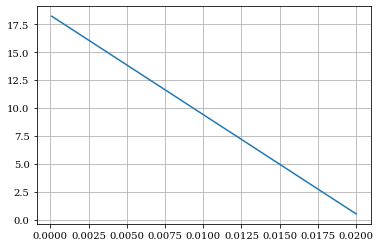

In [9]:
# # Fair Rates (m, me)
# me = np.linspace(0.0001, 0.02)
# loss = []
# for i in me:
#     temp = rsln_gmmb_fst(S0, G, T, r, sigma, m, i, A, Pi, N, X)
#     loss.append(temp)
# plt.plot(me, loss)
# plt.grid()
# f = interpolate.PchipInterpolator(loss[::-1], me[::-1])
# me = f(0) # fair rate of me
# float(me) # 0.01618542071140719

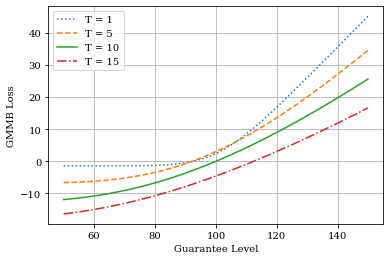

In [18]:
# 50 years old
guarantee = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
# plt.figure(figsize=(10,6))
for j in range(len(time)):
    v = []
    for i in guarantee:
        temp = rsln_gmmb_fst(S0, i, time[j], r, sigma, m, me, A, Pi, N, X)
        v.append(temp)
    plt.plot(guarantee, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Guarantee Level')
plt.ylabel('GMMB Loss')
plt.grid()

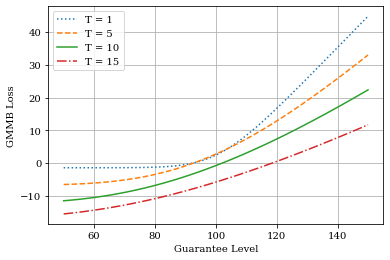

In [37]:
# 60 years old
guarantee = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
# plt.figure(figsize=(10,6))
for j in range(len(time)):
    v = []
    for i in guarantee:
        temp = rsln_gmmb_fst(S0, i, time[j], r, sigma, m, me, A, Pi, N, X)
        v.append(temp)
    plt.plot(guarantee, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Guarantee Level')
plt.ylabel('GMMB Loss')
plt.grid()

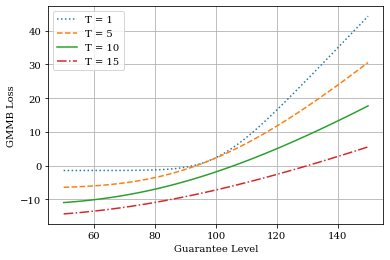

In [41]:
# 70 years old
guarantee = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
# plt.figure(figsize=(10,6))
for j in range(len(time)):
    v = []
    for i in guarantee:
        temp = rsln_gmmb_fst(S0, i, time[j], r, sigma, m, me, A, Pi, N, X)
        v.append(temp)
    plt.plot(guarantee, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Guarantee Level')
plt.ylabel('GMMB Loss')
plt.grid()

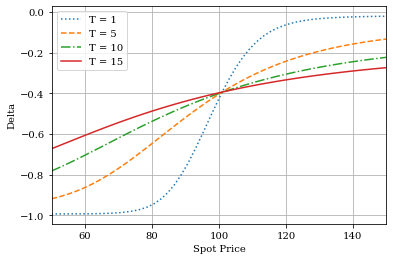

In [107]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = rsln_gmmbdelta_fst(i, G, time[j], r, sigma, m, me, A, Pi, N, X)
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.xlim((50, 150))
plt.ylabel('Delta')
# plt.ylim((-1, 0))
plt.grid()

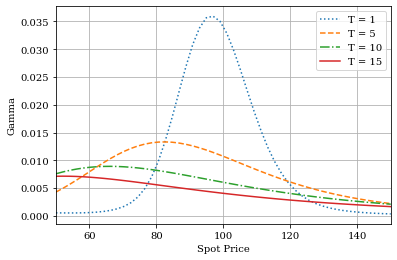

In [108]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = rsln_gmmbgamma_fst(i, G, time[j], r, sigma, m, me, A, Pi, N, X)
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.xlim((50, 150))
plt.ylabel('Gamma')
# plt.ylim((0, 0.035))
plt.grid()

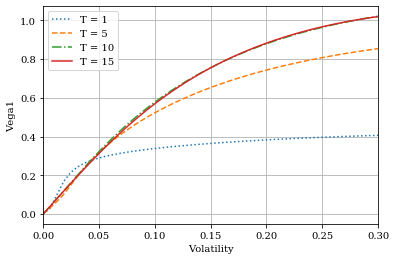

In [109]:
vol1 = np.linspace(0, 0.3)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in vol1:
        vol = [i, sigma[1]]
        temp = rsln_gmmbvega_fst(S0, G, time[j], r, vol, m, me, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(vol1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Volatility')
plt.xlim((0, 0.3))
plt.ylabel('Vega1')
plt.grid()

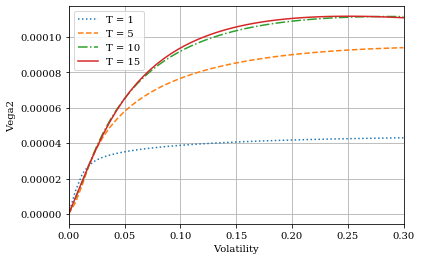

In [112]:
vol2 = np.linspace(0, 0.3)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in vol2:
        vol = [sigma[0], i]
        temp = rsln_gmmbvega_fst(S0, G, time[j], r, vol, m, me, A, Pi, N, X)[1]
        v.append(temp)
    plt.plot(vol2, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Volatility')
plt.xlim((0, 0.3))
plt.ylabel('Vega2')
plt.grid()

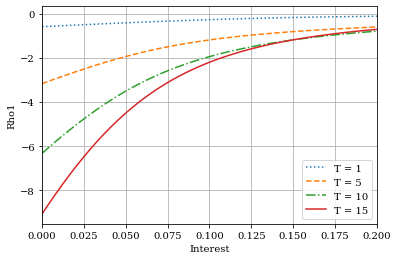

In [113]:
rho1 = np.linspace(0, 0.2)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in rho1:
        interest = [i, r[1]]
        temp = rsln_gmmbrho_fst(S0, G, time[j], interest, sigma, m, me, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(rho1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Interest')
plt.xlim((0, 0.2))
plt.ylabel('Rho1')
plt.grid()

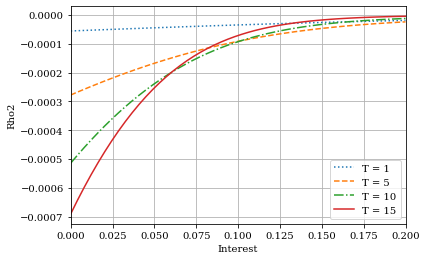

In [114]:
rho2 = np.linspace(0, 0.2)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in rho2:
        interest = [r[0], i]
        temp = rsln_gmmbrho_fst(S0, G, time[j], interest, sigma, m, me, A, Pi, N, X)[1]
        v.append(temp)
    plt.plot(rho2, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Interest')
plt.xlim((0, 0.2))
plt.ylabel('Rho2')
plt.grid()

## Unhedged

In [3]:
# Simulation
def rsln_mc(S0, G, T, r, sigma, m, A, Pi, I):
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    l1, l2 = A[0, 1], A[1, 0]
    if Pi[0] > Pi[1]:
        Ini_State = 1.0
    else:
        Ini_State = 2.0
    Stock = np.zeros((T + 1, I))
    for t in range(T + 1):
        for i in range(I):
            LogStock0 = float(np.log(S0))
            Cur_Time = 0.0
            Cur_State = Ini_State
            tau1 = 0.0
            while Cur_Time < t: # Pr(tau_i > t) = exp(-lambda_i * t)
                p = npr.uniform(0, 1)
                if Cur_State == 1:
                    ExpRV = -1 * np.log(p) / l1
                else:
                    ExpRV = -1 * np.log(p) / l2
                if Cur_Time + ExpRV < t and Cur_State == 1:
                    tau1 = tau1 + ExpRV
                else:
                    if Cur_State == 1:
                        tau1 = tau1 + t - Cur_Time
                Cur_Time = Cur_Time + ExpRV
                if Cur_State == 1:
                    Cur_State = 2
                else:
                    Cur_State = 1
            SimRand = float(npr.standard_normal())
            LogStock = LogStock0 + (r1 - m - 0.5 * sigma1 ** 2) * tau1 + (r2 - m - 0.5 * sigma2 ** 2) * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2)
            Stock[t, i] = np.exp(LogStock)   
    return Stock
Stock = rsln_mc(S0, G, T, drift, sigma, 0, A, Pi, Path)
Stock.shape

(11, 1000)

In [4]:
r1, r2 = r[0], r[1]
sigma1, sigma2 = sigma[0], sigma[1]
l1, l2 = A[0, 1], A[1, 0]
if Pi[0] > Pi[1]:
    Ini_State = 1.0
else:
    Ini_State = 2.0
Stock = np.zeros((T + 1, Path))
for t in range(T + 1):
    for i in range(Path):
        LogStock0 = float(np.log(S0))
        Cur_Time = 0.0
        Cur_State = Ini_State
        tau1 = 0.0
        while Cur_Time < t: # Pr(tau_i > t) = exp(-lambda_i * t)
            p = npr.uniform(0, 1)
            if Cur_State == 1:
                ExpRV = -1 * np.log(p) / l1
            else:
                ExpRV = -1 * np.log(p) / l2
            if Cur_Time + ExpRV < t and Cur_State == 1:
                tau1 = tau1 + ExpRV
            else:
                if Cur_State == 1:
                    tau1 = tau1 + t - Cur_Time
            Cur_Time = Cur_Time + ExpRV
            if Cur_State == 1:
                Cur_State = 2
            else:
                Cur_State = 1
        SimRand = float(npr.standard_normal())
        LogStock = LogStock0 + (r1 - m - 0.5 * sigma1 ** 2) * tau1 + (r2 - m - 0.5 * sigma2 ** 2) * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2)
        Stock[t, i] = np.exp(LogStock)   

In [7]:
np.mean(Stock,1)

array([100.        , 101.0832689 , 101.75078264, 101.77051552,
       102.61585883, 103.9181208 , 104.4784124 , 104.85889404,
       104.24265481, 102.35530476, 101.30117289])

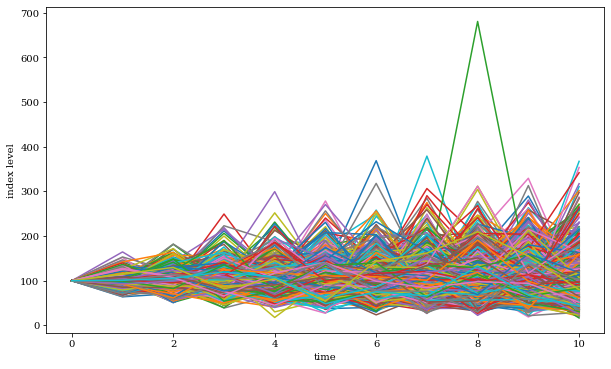

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(Stock[:, :], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level');

In [22]:
# Performance of Unhedged Portfolio
for j in range(T+1):
    Unhedged = []
    for i in Stock[j]:
        temp = rsln_gmmb_fst(i, G, T-j, r, sigma, m, me, A, Pi, N, X)
        Unhedged.append(temp)
    print(j, np.mean(Unhedged), np.std(Unhedged))

0 3.232969447708456e-13 0.0
1 -0.37116550000612536 5.437945593509031
2 -0.8507057922366558 6.635004403853397
3 0.5366113608672246 9.074819601301717
4 0.33672994687837493 10.40640110511398
5 0.3578685035207577 10.036664256561652
6 1.8701690455539195 12.332973230305866
7 2.273923054582427 12.717974779913126
8 5.349363563232831 15.42864065825955
9 5.917679298414835 17.43166387201124
10 7.203390715583415 15.16348943330995


In [ ]:
# 50
0 3.232969447708456e-13 0.0
1 -0.26765144392941687 5.737660052272854
2 -1.616550258971325 5.6385251199495485
3 -1.4409319089865087 9.826491578003859
4 0.4447014637762727 11.052148031007464
5 4.637675289561003 14.044509419744305
6 0.09495701585452529 12.70870831677728
7 5.640959420341627 16.64430204614654
8 5.893905917473153 15.055504803836225
9 4.2551020509140685 13.466551907584067
10 7.215510266635891 15.72057286780695

## Static

In [18]:
def portfolio(S, G, t, r, sigma, m, me, A, Pi, N, X):
    matrix = np.zeros((7, 8))
    # GMMB(10) = Put(10 + Put(11) + Put(12) + f(10 + f(11) + Z(10) + Z(11)
    matrix[0, 0] = rsln_gmmb_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    matrix[1, 0] = rsln_gmmbdelta_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    matrix[2, 0] = rsln_gmmbgamma_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    matrix[3, 0] = rsln_gmmbrho_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)[0]
    matrix[4, 0] = rsln_gmmbvega_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)[0]
    matrix[5, 0] = rsln_gmmbmu_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    matrix[6, 0] = rsln_gmmbmu2_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    for j in range(3): # Put(10), Put(11), Put(12)
        matrix[0, j+1] = rsln_put_fst(S, G, t+j, r, sigma, 0, A, Pi, N, X)
        matrix[1, j+1] = rsln_putdelta_fst(S, G, t+j, r, sigma, 0, A, Pi, N, X)
        matrix[2, j+1] = rsln_putgamma_fst(S, G, t+j, r, sigma, 0, A, Pi, N, X)
        matrix[3, j+1] = rsln_putrho_fst(S, G, t+j, r, sigma, 0, A, Pi, N, X)[0]
        matrix[4, j+1] = rsln_putvega_fst(S, G, t+j, r, sigma, 0, A, Pi, N, X)[0]
    for j in range(2): # f(10), f(11), Z(10), Z(11)
        matrix[0, j+4] = s(10+j) * z(r, t+j, A, Pi) # Price
        matrix[3, j+4] = s(10+j) * rho1_z(r, t+j, A, Pi) # Rho1
        matrix[5, j+4] = b(10+j) * s(10+j) * z(r, t+j, A, Pi) # Mu
        matrix[6, j+4] = b(10+j) ** 2 * s(10+j) * z(r, t+j, A, Pi) # Mu2
        matrix[0, j+6] = z(r, t+j, A, Pi) # Price
        matrix[3, j+6] = rho1_z(r, t+j, A, Pi) # Rho1
    weights = np.zeros((8))
    weights[0] = -1
    weights[1:] = lin.solve(matrix[:, 1:], matrix[:, 0])
    return (matrix, weights)
Results = portfolio(S0, G, T, r, sigma, m, me, A, Pi, N, X)
print(Results)
Matrix0 = Results[0]
W_0 = Results[1]

(array([[ 5.32907052e-13,  8.76331845e+00,  8.88281348e+00,
         8.96190500e+00,  7.21721867e-01,  6.97643619e-01,
         7.78418037e-01,  7.61056976e-01],
       [-4.00702275e-01, -2.17639230e-01, -2.09307602e-01,
        -2.01393055e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.04597698e-03,  5.84790106e-03,  5.41480474e-03,
         5.03994616e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-3.96444453e+00, -3.05236016e+00, -3.27910479e+00,
        -3.49173421e+00, -7.21646548e-02, -7.67327893e-02,
        -7.78336802e-02, -8.37075306e-02],
       [ 5.77162378e-01,  5.84731493e-01,  5.95568441e-01,
         6.04732221e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.24700571e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.10261408e+01, -1.22615907e+01,
         0.00000000e+00,  0.00000000e+00],
       [ 2.37714871e+03,  0.00000

In [19]:
def pv(S, t): # Present Value
    vector = np.zeros(8)
    vector[0] = rsln_gmmb_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    for j in range(3): # Put(10), Put(11), Put(12)
        vector[j+1] = rsln_put_fst(S, G, t+j, r, sigma, 0, A, Pi, N, X)
    for j in range(2): # f(15), f(16), Z(15), Z(16)
        vector[j+4] = s(10+j) * z(r, t+j, A, Pi)
        vector[j+6] = z(r, t+j, A, Pi)
    return vector

In [43]:
def reg_weights_3(p):
    w1, w4, w6 = p
    matrix = Matrix0
    weights = np.array([w1, 0, 0, w4, 0, w6, 0])
    Bx = matrix[:, 1:].dot(weights)
    C = matrix[:, 0]
    return (Bx - C).dot(Bx - C)
bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000))
sco.minimize(reg_weights_3, [0.1, 0.1, 0.1], method='SLSQP', bounds=bnds)

     fun: 950.7714558605529
     jac: array([ 7.62939453e-06, -1.44958496e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([  1.76576562,  14.09973953, -32.93601186])

In [59]:
def reg_weights(p):
    w1, w2, w3, w4, w5, w6, w7 = p
    matrix = Matrix0
    weights = np.array([w1, w2, w3, w4, w5, w6, w7])
    Bx = matrix[:, 1:].dot(weights)
    C = matrix[:, 0]
    return (Bx - C).dot(Bx - C) + 10 * np.sum(np.abs(weights))

#cons = ({'type': 'ineq', 'fun': lambda p: 100 - p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2 - p[4]**2 - p[5]**2 - p[6]**2})
bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000)) 
sco.minimize(reg_weights, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], method='SLSQP', bounds=bnds)

     fun: 237.74407948792685
     jac: array([ 0.02373505, -1.62142372, -3.31570435, -1.03015137, -1.30922699,
       12.8711853 , 12.73363113])
 message: 'Optimization terminated successfully.'
    nfev: 639
     nit: 57
    njev: 57
  status: 0
 success: True
       x: array([-5.48237040e-01,  7.29373722e-08, -1.81594942e-07, -3.18881327e+00,
        1.35213786e+01, -1.69670640e-08,  1.87799720e-07])

In [31]:
def opt_weights(p):
    w1, w2, w3, w4, w5, w6, w7 = p
    matrix = Matrix0
    weights = np.array([w1, w2, w3, w4, w5, w6, w7])
    Bx = matrix[:, 1:].dot(weights)
    C = matrix[:, 0]
    return np.sum((Bx - C) ** 2)
bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000)) 
sco.minimize(opt_weights, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], method='SLSQP', bounds=bnds)

     fun: 0.06784418239281335
     jac: array([2.51410622e-03, 2.71404907e-03, 2.55764648e-03, 2.67157406e-02,
       3.36616132e-02, 3.30287032e-04, 9.22577456e-05])
 message: 'Optimization terminated successfully.'
    nfev: 185
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([ -2.56736114,   0.07661083,   3.58882855,  -7.31825074,
        16.75090425, -11.32428309, -10.4227717 ])

In [22]:
W_lin = np.array([-1, -228.80152969, 496.9425498, -267.22352691, -7.31831572, 16.75095472, -953.58168627, 948.05690719])
W_reg = np.array([-1, 1.76577709, 0, 0, 14.09973953, 0, -32.93615171, 0])
W_opt = np.array([-1, -2.56736114, 0.07661083, 3.58882855, -7.31825074, 16.75090425, -11.32428309, -10.4227717])

In [25]:
for t in range(T+1): # j = 0,1,2,...,15
    Static = []
    for i in Stock[t]:
        pvt = pv(i, T-t) # present value at time t
        Static.append(pvt.dot(W_lin))
    print(t, np.mean(Static), np.std(Static))

0 -1.6085550669231452e-08 0.0
1 -0.9187370463133697 0.22296384312825004
2 -2.0587860657960193 0.7183615902504412
3 -3.221842257832908 1.7019782338695784
4 -5.6391466598721784 2.9694692202020834
5 -8.633621886838172 5.595265104216408
6 -12.06850974037071 10.27053709826761
7 -19.998768268101195 15.685743253086608
8 -35.6289841452504 28.109691568273657
9 -51.876967952176294 39.513760734666306
10 -100.5545217167172 117.89185823012342


In [29]:
for t in range(T+1): # j = 0,1,2,...,15
    Static = []
    for i in Stock[t]:
        pvt = pv(i, T-t) # present value at time t
        Static.append(pvt.dot(W_reg))
    print(t, np.mean(Static), np.std(Static))

0 0.012062709601362798 0.0
1 -1.0951684371951864 0.5188891941509505
2 -1.8696982683123315 1.3665957745923027
3 -3.078885561186746 2.8800831315473143
4 -4.408397173582684 3.8882105960424482
5 -5.021945060497675 4.672022412792878
6 -6.210340185935135 5.793402635636629
7 -9.025987884766153 5.137506174149797
8 -8.632803700315929 8.597684333035048
9 -11.45891656812338 10.228633410451176
10 -14.436721393078193 10.865967758807454


In [ ]:
# 50
0 0.012062709601362798 0.0
1 -1.0951684371951864 0.5188891941509505
2 -1.8696982683123315 1.3665957745923027
3 -3.078885561186746 2.8800831315473143
4 -4.408397173582684 3.8882105960424482
5 -5.021945060497675 4.672022412792878
6 -6.210340185935135 5.793402635636629
7 -9.025987884766153 5.137506174149797
8 -8.632803700315929 8.597684333035048
9 -11.45891656812338 10.228633410451176
10 -14.436721393078193 10.865967758807454

In [22]:
for t in range(T+1): # j = 0,1,2,...,15
    Static = []
    for i in Stock[t]:
        pvt = pv(i, T-t) # present value at time t
        Static.append(pvt.dot(W_opt))
    print(t, np.mean(Static), np.std(Static))

0 0.001727533332214648 0.0
1 0.11850941818306673 2.175500506619949
2 -0.2981348333168824 3.751645422718611
3 -1.6978282598405172 4.466431903261276
4 -2.332313845762483 4.519152124028301
5 -2.9649911162868103 5.483260791825203
6 -4.346906090069621 5.725153244032063
7 -6.053427246487754 6.333947205350335
8 -8.579651391118837 7.4251501315215895
9 -13.149133598008591 8.14239357119625
10 -15.558817638727703 8.461372145015048


In [ ]:
# 50
0 0.001727533332214648 0.0
1 -0.4257901240440423 2.4240379385505935
2 -0.5760042869804122 4.180420612478524
3 -1.1982410108984292 4.612758736048369
4 -2.2494052320446025 4.707093226289403
5 -3.4801217391773407 5.918061201088433
6 -4.976006828720916 6.176556056979236
7 -5.433793836202933 4.668066155913173
8 -8.89712930237398 6.926837599176258
9 -11.239720912591952 7.149382325284964
10 -14.871942025731355 8.245560013107658

## Semi-static

In [50]:
Weights = np.zeros((T+1, Path, 8)) # (Weights4, Weights8, Weights12) * scenario * 8
Weights[0] = weights0
for t in [2, 4, 6, 8]:
    fund = Fund[t]
    for i in range(len(fund)):
        Weights[t, i] = portfolio(fund[i], G, T-t, r, sigma, m, me, A, Pi, N, X)[1]

In [51]:
for t in range(T + 1):
# for t in range(0, 6):
    Semi = []
    if t < 2:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(weights0))
    elif 2 <= t < 4:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[2, i]))
    elif 4 <= t < 6:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[4, i]))
    elif 6 <= t < 8:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[6, i]))
    elif 8 <= t:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[8, i]))
    print(t, np.mean(Semi), np.std(Semi))

0 4.547473508864641e-13 0.0
1 -2.151283387956626 0.24215634967839467
2 2.4632148173016805e-13 1.3297256721612599e-12
3 -9.059285712288203 33.53375115744339
4 5.731711401798141e-14 1.7789066472982782e-13
5 -17.496891613372025 43.82815871596232
6 2.6053233644537005e-15 4.707788761757979e-14
7 -87.31467004880606 352.729384884285
8 1.1842378929335002e-15 2.2320606785052116e-14
9 298.95397329298135 2373.6572817950314
10 10376.48239096066 40003.04548862795


In [30]:
Weights = np.zeros((T+1, Path, 8)) # (Weights4, Weights6, Weights9, Weights12) * scenario * 8
Weights[0] = weights0
for t in [5, 10]:
# for t in [0]:
    fund = Fund[t]
    for i in range(len(fund)):
        Weights[t, i] = portfolio(fund[i], G, T-t, r, sigma, m, me, A, Pi, N, X)[1]

In [30]:
for t in range(T + 1):
# for t in range(0, 6):
    Semi = []
    if t < 5:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(weights0))
    elif 5 <= t < 10:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[5, i]))
    elif 10 <= t:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[10, i]))
    print(t, np.mean(Semi), np.std(Semi))

0 4.547473508864641e-13 0.0
1 -1.9953080356040005 0.1844029316011282
2 -4.28912411857379 0.7580450884048642
3 -7.085620205618374 1.6231927879333252
4 -9.604811475408926 2.9654615253516923
5 4.3698378249246164e-14 7.617319704349045e-14
6 -2.3518869833963323 5.360194520125324
7 -5.1249379407920115 12.924832676967997
8 -9.135799608507629 7.608884865454444
9 -19.362646936125618 29.152923596334087
10 8.19940380050571e-17 1.935391837875354e-15
